In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/MartinNovotny25/VUT-FIT-KNN/blob/main/sam_baseline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-84nyh9__
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-84nyh9__
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=16a68a2539d7778ab405c37eab48405ab9b230d5c98b3aaebe41a798b3b8a227
  Stored in directory: /tmp/pip-ephem-wheel-cache-4x7vazap/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-04-09 08:07:51--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import distance_transform_bf

def get_random_click(ground_truth, prediction):
    prediction = prediction.astype(bool)
    ground_truth = ground_truth.astype(bool)

    prediction = prediction.astype(int)
    gt = ground_truth.astype(int)

    prediction = np.array(prediction)
    ground_truth = np.array(ground_truth)

    prediction = prediction.astype(int)
    gt = ground_truth.astype(int)
    D_map = gt - prediction

    D_plus = D_map.copy()
    D_minus = D_map.copy()
    D_plus[D_plus < 0] = 0  # D_plus are false-negative pixels
    D_minus[D_minus > 0] = 0  # D_minus are false-positive pixels
    D_minus = np.abs(D_minus)

    # sum non zero elements of D_minus and D_plus
    sum_D_minus = np.sum(D_minus)
    sum_D_plus = np.sum(D_plus)

    click_type = 0
    if (sum_D_minus > sum_D_plus):
        click_type = 0
        selected_map = D_minus
    else:
        click_type = 1
        selected_map = D_plus

    # get distances of each pixel to the nearest border
    sel_map_transformed = distance_transform_bf(selected_map)
    # make the distances even more significant
    sel_map_exp = np.expm1(sel_map_transformed)
    # change the distances to probabilities of a given pixel being selected
    if np.sum(sel_map_exp) != 0:
        P_map = sel_map_exp / np.sum(sel_map_exp)

        # select a random pixel based on the probabilities
        flattened_probabilities = P_map.flatten()

        random_pixel_index = np.random.choice(np.arange(len(flattened_probabilities)), p=flattened_probabilities)
        random_pixel_2d_index = np.unravel_index(random_pixel_index, P_map.shape)
        return random_pixel_2d_index, click_type
    else:
        pred_white = []
        # iterate over every pixel, if it is white, add it to list
        for i in range(prediction.shape[0]):
            for j in range(prediction.shape[1]):
                if prediction[i, j] == 1:
                    pred_white.append((i, j))

        # select middle pixel
        random_pixel_2d_index = pred_white[int(len(pred_white)/2)]
        return random_pixel_2d_index, click_type

## Example image

In [ ]:
image = cv2.imread('images/benign(1).png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
predictor.set_image(image)

To select an abdomen part, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image. The example input image is resized for easier point selection.

In [ ]:
input_point = np.array([[320, 150]])
input_label = np.array([1])

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

(3, 471, 562)

In [ ]:
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     print(score)

print(scores[0])


0.9779326


## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[320, 150], [400, 150]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, scores, logist = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
print(scores)

[0.9573219]


In [ ]:
test_image= cv2.imread('images/benign(1).png', cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread('images/benign(1)_mask.png', cv2.IMREAD_GRAYSCALE)
prediction = cv2.imread('images/benign(1)_mask.png', cv2.IMREAD_GRAYSCALE)


# test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
# ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)
# prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)

input_points = np.array([])
input_labels = np.array([])
masks_eval = []
scores_eval = []

initial_click = True
for i in range(5):
  random_pixel_2d_index, click_type = get_random_click(ground_truth, prediction)
  input_points.append(random_pixel_2d_index)
  input_labels.append(click_type)


  masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True,
  )

  prediction = masks[0]
  #mask_input = logits[np.argmax(scores), :, :]
  masks_eval.append(masks[0])
  scores_eval.append(scores[0]) # zisti kde je score

print(scores_eval)


AttributeError: 'NoneType' object has no attribute 'shape'

------------ IMAGE  images/benign(2).png   images/benign(2)_mask.png   images/benign(2)_mask.png -----------------------
---------1 CLICK----------
1
[[262 200]]


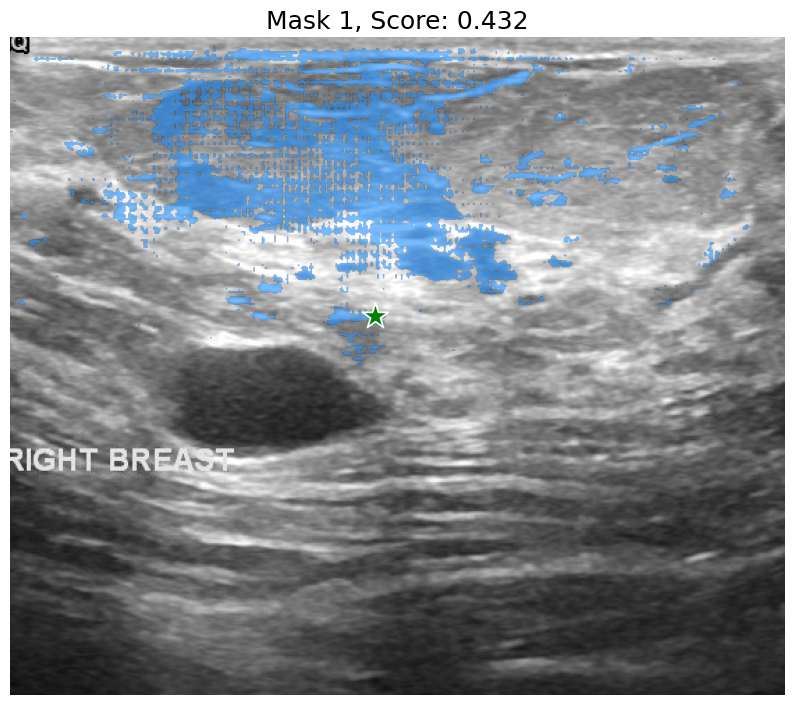

1
[[262 200]]


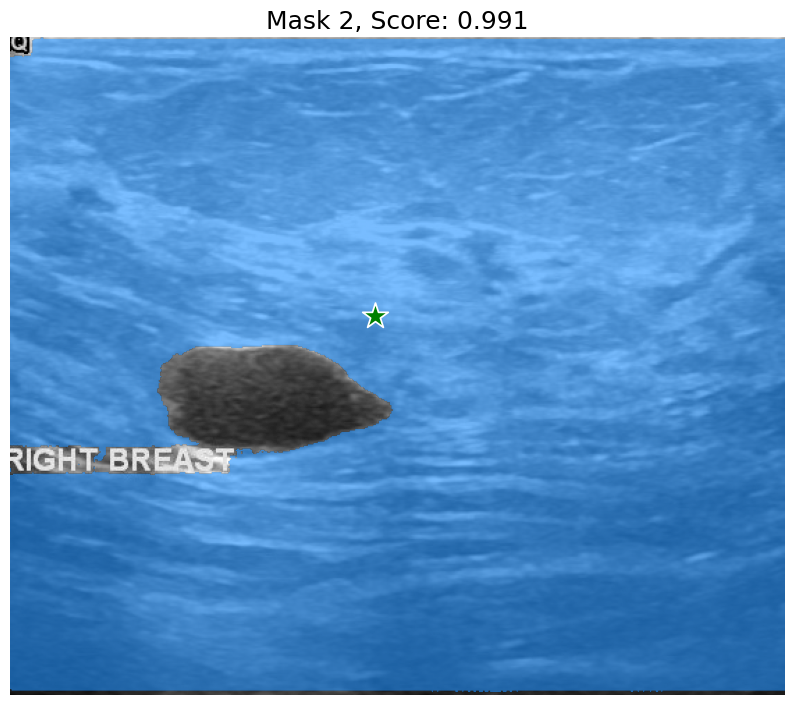

1
[[262 200]]


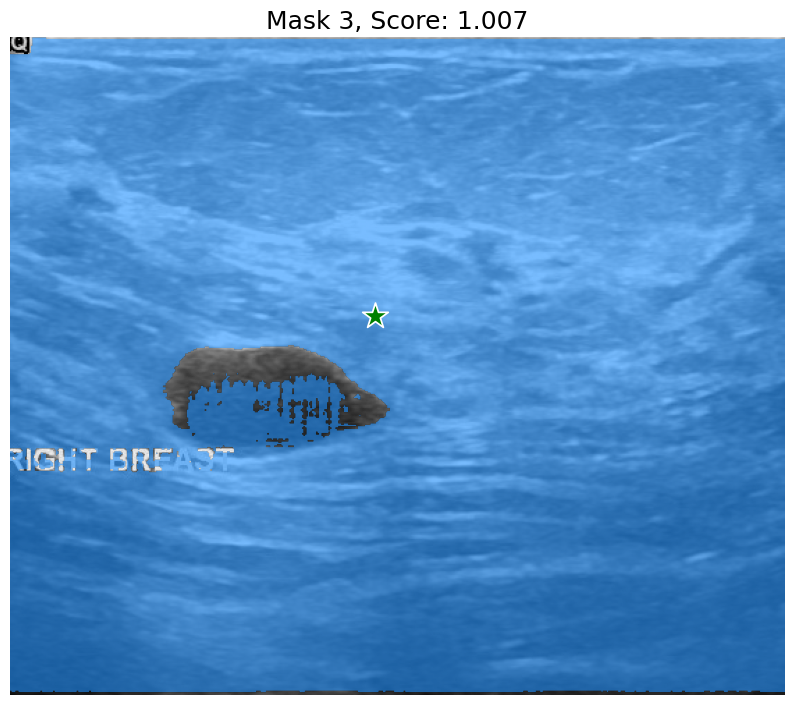

---------MULTIPLE CLICK----------
0
[[262 200]
 [124 269]]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 1

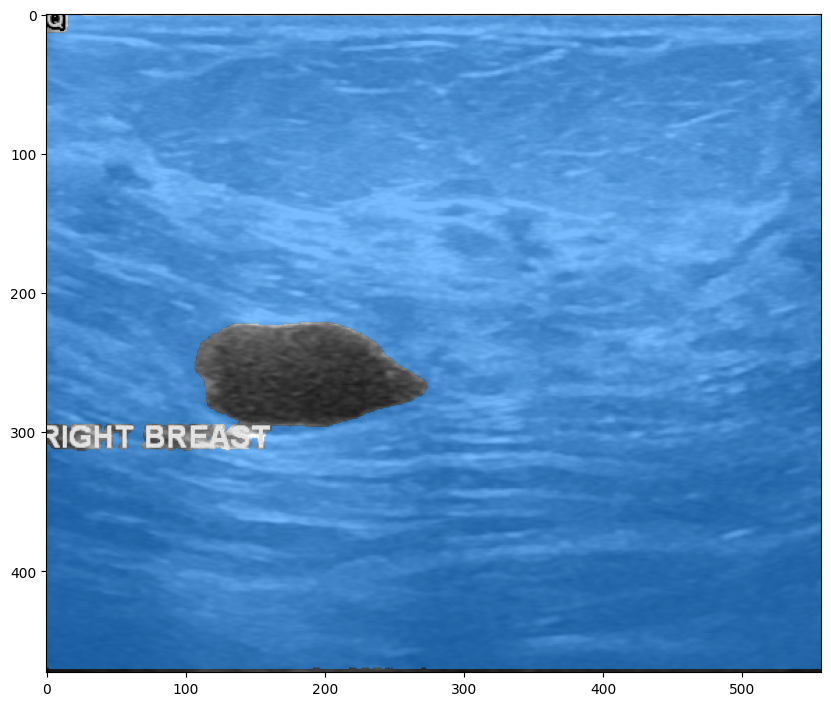

In [ ]:
# Image sources
input_images = ['images/benign(3).png', 'images/benign(4).png', 'images/benign(5).png']
predictions = ['images/benign(3)_mask.png', 'images/benign(4)_mask.png', 'images/benign(5)_mask.png']
ground_truths = ['images/benign(3)_mask.png', 'images/benign(4)_mask.png', 'images/benign(5)_mask.png']


#number of clicks
num_of_clicks = 15

#click lists
click_list = []
type_list = []

# generate clicks
for input, prediction_image, gt_image in zip(input_images, predictions,ground_truths):
    print("------------ IMAGE ",input, " ", prediction_image, " ", gt_image, "-----------------------")

    # Load images
    input_image = cv2.imread(input, cv2.IMREAD_GRAYSCALE)
    prediction = cv2.imread(prediction_image, cv2.IMREAD_GRAYSCALE)
    ground_truth = cv2.imread(gt_image, cv2.IMREAD_GRAYSCALE)

    # Convert grayscale images so SAM accepts them
    conv_input_image = np.expand_dims(input_image, axis=2)
    conv_input_image = np.repeat(conv_input_image, 3, axis=2)
    conv_prediction = np.expand_dims(prediction, axis=2)
    conv_prediction = np.repeat(conv_prediction, 3, axis=2)
    conv_ground_truth = np.expand_dims(ground_truth, axis=2)
    conv_ground_truth = np.repeat(conv_ground_truth, 3, axis=2)

      for i in range(clicks):

          # Generate clicks and append them to the list
          random_pixel_2d_index, click_type = get_random_click(ground_truth, prediction)
          click_list.append(list(random_pixel_2d_index))
          type_list.append(click_type)

          click_list_np = np.array(click_list)
          type_list_np = np.array(type_list)

          # Convert grayscale images so SAM accepts them
          # Here, a output mask from the model should be loaded into prediction
          conv_prediction = np.expand_dims(prediction, axis=2)
          conv_prediction = np.repeat(conv_prediction, 3, axis=2)

          # Set predictor to our image
          predictor.set_image(conv_input_image)

          # Generate masks, scores and logits
          # for multiple clicks, only best mask input is selected -- OPTIONAL
          if len(type_list) == 1:
            print("---------1 CLICK----------")
            masks, scores, logits = predictor.predict (
                point_coords = click_list_np,
                point_labels = type_list_np,
                )
          else:
            print("---------MULTIPLE CLICK----------")
            mask_input = logits[np.argmax(scores), :, :]
            masks, scores, logits = predictor.predict(
              point_coords = click_list_np,
              point_labels = type_list_np,
              mask_input=mask_input[None, :, :],
              multimask_output=False
          )

          # Show masks

          # for i, (mask, score) in enumerate(zip(masks, scores)):
          #   plt.figure(figsize=(10,10))
          #   plt.imshow(input_image,cmap='gray')
          #   show_mask(mask, plt.gca())
          #   print(np.array(click_type))
          #   print(np.array(click_list))
          #   show_points(np.array(click_list), np.array([click_type]), plt.gca())
          #   plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
          #   plt.axis('off')
          #   plt.show()

          # Save the mask/mby then use imread to read it again and
          # assign in to prediction
          # TODO

          # Assign new mask
          prediction = masks[0] # doesnt work

    # Clear the lists for new images
    click_list.clear()
    type_list.clear()
